<a href="https://colab.research.google.com/github/AyTIDa1165/AccidentDetectionUsingCCTV/blob/main/SML_AccidentDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All the Imported Modules

In [ ]:
# import cupy as np
import numpy as np
from PIL import Image
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import joblib
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Function Definations

In [ ]:
def jpeg_to_numpy(image_folder, image_size=(240, 240)):

 # Get list of image file names
    image_files = [file for file in os.listdir(image_folder) if file.endswith('.jpg')]
    total_images = len([filename for filename in os.listdir(image_folder) if filename.endswith((".jpg", ".jpeg"))])
    processed_images = 0
    # Initialize numpy array to store images
    num_images = len(image_files)
    numpy_array = np.zeros((num_images,) + image_size + (3,), dtype=np.uint8)

    # Load and resize images, then store in numpy array
    for i, file in enumerate(image_files):
        processed_images += 1
        print(f"Processed: {processed_images}/{total_images}", end="\r")
        image_path = os.path.join(image_folder, file)
        image = Image.open(image_path)
        image = np.array(image)  # Convert PIL image to numpy array
        image = resize(image, image_size, anti_aliasing=True)
        numpy_array[i] = np.uint8(image * 255)  # Convert back to uint8

    return numpy_array

def pca_fit(X, n_components):
    # Center the data
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    # Compute covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Select top n_components eigenvectors
    principal_components = sorted_eigenvectors[:, :n_components]

    # Return principal components and mean for later use in transformation
    return principal_components, mean

def pca_transform(X, principal_components, mean):
    # Center the data using the mean of the training set
    X_centered = X - mean

    # Project the centered data onto the principal components
    transformed_data = np.dot(X_centered, principal_components)

    return transformed_data

def printdistribution(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    for i in range(len(unique_elements)):
        print(unique_elements[i],":",counts[i])

def process_and_predict(image_path, model, ipca):

    image_size = (240, 240)
    numpy_array = np.zeros(image_size + (3,), dtype=np.uint8)

    # Load and resize the image
    image = Image.open(image_path)
    img_resized = image.resize((240, 240))
    image = np.array(img_resized)  # Convert PIL image to numpy array
    image = resize(image, image_size, anti_aliasing=True)
    numpy_array = np.uint8(image * 255)  # Convert back to uint8

    # Reshape the image array
    image_reshaped = numpy_array.reshape(1, -1)
    # Apply Incremental PCA transformation
    image_pca = ipca.transform(image_reshaped)

    # Predict using the model
    prediction = model.predict(image_pca)

    # Plot the image
    plt.imshow(numpy_array)
    plt.title(f'Prediction: {"Accident" if prediction[0] > 0.5 else "Non-Accident"}')
    plt.axis('off')
    plt.show()



Load numpy arrays from files

In [ ]:
accident_data_train = np.load("/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/Accident/TrainNumpy.npy")
non_accident_data_train = np.load("/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/Non-Accident/TrainNumpy.npy")

# accident_data_val = np.load(r"C:\Users\mehul\Downloads\RoadAccidentDatabaseNumpy\Accident\ValNumpy.npy")
# non_accident_data_val = np.load(r"C:\Users\mehul\Downloads\RoadAccidentDatabase\Non-Accident\ValNumpy.npy")

accident_data_test = np.load("/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/Accident/TestNumpy.npy")
non_accident_data_test = np.load("/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/Non-Accident/TestNumpy.npy")

Create labels for each dataset

In [ ]:
accident_labels_train = np.ones(accident_data_train.shape[0], dtype=np.int8)  # Assign label 1 to accident data
non_accident_labels_train = np.zeros(non_accident_data_train.shape[0], dtype=np.int8)  # Assign label 0 to non-accident data

# accident_labels_val  = np.ones(accident_data_val.shape[0], dtype=np.int8)  # Assign label 1 to accident data
# non_accident_labels_val  = np.zeros(non_accident_data_val.shape[0], dtype=np.int8)  # Assign label 0 to non-accident data

accident_labels_test = np.ones(accident_data_test.shape[0], dtype=np.int8)  # Assign label 1 to accident data
non_accident_labels_test = np.zeros(non_accident_data_test.shape[0], dtype=np.int8)  # Assign label 0 to non-accident data

Making the number of data points of each class equal and shuffling the data

In [ ]:
num_accident_samples = len(accident_data_train)
num_non_accident_samples = len(non_accident_data_train)
print(num_accident_samples)
# Determine the minimum number of samples between the two classes
min_samples = 5000 #Reducing the size of the data due to computational constraints

# Randomly select a subset of samples from each class to make them equal
accident_indices = np.random.choice(num_accident_samples, min_samples, replace=False)
non_accident_indices = np.random.choice(num_non_accident_samples, min_samples, replace=False)

balanced_accident_data_train = accident_data_train[accident_indices]
balanced_non_accident_data_train = non_accident_data_train[non_accident_indices]

balanced_accident_labels_train = accident_labels_train[accident_indices]
balanced_non_accident_labels_train = non_accident_labels_train[non_accident_indices]

10469


In [ ]:
del accident_data_train, non_accident_data_train

Making the number of data points of test set for each class equal and shuffling the data

In [ ]:
num_accident_samples = len(accident_data_test)
num_non_accident_samples = len(non_accident_data_test)
# Determine the minimum number of samples between the two classes
min_samples = 500

# Randomly select a subset of samples from each class to make them equal
accident_indices = np.random.choice(num_accident_samples, min_samples, replace=False)
non_accident_indices = np.random.choice(num_non_accident_samples, min_samples, replace=False)

balanced_accident_data_test = accident_data_test[accident_indices]
balanced_non_accident_data_test = non_accident_data_test[non_accident_indices]

balanced_accident_labels_test = accident_labels_test[accident_indices]
balanced_non_accident_labels_test = non_accident_labels_test[non_accident_indices]

In [ ]:
del accident_data_test, non_accident_data_test

Join the data and Labels

In [ ]:
x_train = np.concatenate((balanced_accident_data_train, balanced_non_accident_data_train), axis=0)
y_train = np.concatenate((balanced_accident_labels_train, balanced_non_accident_labels_train), axis=0)

del balanced_accident_data_train, balanced_non_accident_data_train

# x_val = np.concatenate((accident_data_val, non_accident_data_val), axis=0)
# y_val = np.concatenate((accident_labels_val, non_accident_labels_val), axis=0)

x_test = np.concatenate((balanced_accident_data_test, balanced_non_accident_data_test), axis=0)
y_test = np.concatenate((balanced_accident_labels_test, balanced_non_accident_labels_test), axis=0)

del balanced_accident_data_test, balanced_non_accident_data_test

Print the shape of resulting arrays

In [ ]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

# print("Shape of x_val:", x_val.shape)
# print("Shape of y_val:", y_val.shape)

print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (10000, 240, 240, 3)
Shape of y_train: (10000,)
Shape of x_test: (1000, 240, 240, 3)
Shape of y_test: (1000,)


Flatten the input data

In [ ]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

print("Shape of x_train_flat:", x_train_flat.shape)
print("Shape of x_test_flat:", x_test_flat.shape)

Shape of x_train_flat: (10000, 172800)
Shape of x_test_flat: (1000, 172800)


Deleting obsolete Variables

Counting the number of Accidents and Non Accidents in test data

In [ ]:
printdistribution(y_test)

0 : 500
1 : 500


Apply Incremental PCA for dimensionality reduction

In [ ]:
importA = True #Make it false for the firstTime
if importA:
  ipca = joblib.load('/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/ipca_model.pkl')
  x_train_pca = np.load('/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/X_train_pca.npy')
  x_test_pca = np.load('/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/X_test_pca.npy')
  y_train = np.load('/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/y_train.npy')
  y_test = np.load('/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/y_test_sampled.npy')
else:
  ipca = IncrementalPCA(n_components=100)  # Adjust the number of components as needed
  ipca.fit(x_train_flat) #Fit the data and create the transformation matrix.# Save the fitted IPCA object to a file
  joblib.dump(ipca, r'/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/ipca_model.pkl')

  x_train_pca = ipca.transform(x_train_flat)
  np.save(r'/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/X_train_pca.npy', x_train_pca)
  np.save(r'/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/y_train.npy', y_train)

  x_test_pca = ipca.transform(x_test_flat)
  np.save(r'/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/X_test_pca.npy', x_test_pca)
  np.save(r'/content/drive/MyDrive/SML Project/RoadAccidentDatabaseNumpy/y_test_sampled.npy', y_test)

Applying Quadratic Discriminant Analysis

In [ ]:
# Create QDA classifier
qda = QuadraticDiscriminantAnalysis()

# Train the classifier
qda.fit(x_train_pca, y_train)

# Predict on the test set
y_pred = qda.predict(x_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.792


Applying Adaboost Classification

In [ ]:
# Create AdaBoost classifier
ada_boost = AdaBoostClassifier()

# Train the classifier
ada_boost.fit(x_train_pca, y_train)

# Predict on the test set
y_pred = ada_boost.predict(x_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.811


Applying Gradient Boosting

In [ ]:
# # Create Gradient Boosting classifier
# gradient_boosting = GradientBoostingClassifier()

# # Train the classifier
# gradient_boosting.fit(x_train_pca, y_train)

# # Predict on the test set
# y_pred = gradient_boosting.predict(x_test_pca)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

Accuracy: 0.724


Applying Random Forest

In [ ]:
# Create Random Forest classifier
random_forest = RandomForestClassifier()

# Train the classifier
random_forest.fit(x_train_pca, y_train)

# Predict on the test set
y_pred = random_forest.predict(x_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.799


Deep Layer Neural Network

In [ ]:
#Define the model and its layers
model = Sequential([
    Dense(256, activation='relu', input_shape=(x_train_pca.shape[1],)),  # Increase the number of neurons in the first layer
    Dropout(0.5),  # Adding dropout for regularization
    Dense(128, activation='relu'),  # Decrease the number of neurons in the second layer
    Dropout(0.4),  # Adjust dropout rate
    Dense(64, activation='relu'),  # Decrease the number of neurons in the third layer
    Dropout(0.3),  # Adjust dropout rate
    Dense(32, activation='relu'),  # Adding another hidden layer with fewer neurons
    Dropout(0.2),  # Adjust dropout rate
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(x_train_pca, y_train, epochs=50, batch_size=32, callbacks=[early_stopping])

loss, accuracy = model.evaluate(x_test_pca, y_test)
print("Test Accuracy:", accuracy*100)


Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 133.3054 - accuracy: 0.5708

313/313 [==============================] - 6s 8ms/step - loss: 133.3054 - accuracy: 0.5708
Epoch 2/50
309/313 [============================>.] - ETA: 0s - loss: 15.6030 - accuracy: 0.5620

313/313 [==============================] - 3s 10ms/step - loss: 15.4653 - accuracy: 0.5621
Epoch 3/50
310/313 [============================>.] - ETA: 0s - loss: 3.7088 - accuracy: 0.5336

313/313 [==============================] - 1s 5ms/step - loss: 3.7025 - accuracy: 0.5348
Epoch 4/50
308/313 [============================>.] - ETA: 0s - loss: 2.0756 - accuracy: 0.5191

313/313 [==============================] - 1s 3ms/step - loss: 2.0615 - accuracy: 0.5193
Epoch 5/50
309/313 [============================>.] - ETA: 0s - loss: 1.3532 - accuracy: 0.5372

313/313 [==============================] - 1s 3ms/step - loss: 1.3486 - accuracy: 0.5370
Epoch 6/50
303/313 [============================>.] - ETA: 0s - loss: 1.1566 - accuracy: 0.5367

313/313 [==============================] - 1s 3ms/step - loss: 1.1453 - accuracy: 0.5378
Epoch 7/50
310/313 [============================>.] - ETA: 0s - loss: 1.0341 - accuracy: 0.5321

313/313 [==============================] - 1s 3ms/step - loss: 1.0382 - accuracy: 0.5328
Epoch 8/50
301/313 [===========================>..] - ETA: 0s - loss: 0.9380 - accuracy: 0.5519

313/313 [==============================] - 1s 3ms/step - loss: 0.9305 - accuracy: 0.5518
Epoch 9/50
310/313 [============================>.] - ETA: 0s - loss: 0.8511 - accuracy: 0.5298

313/313 [==============================] - 1s 3ms/step - loss: 0.8500 - accuracy: 0.5298
Epoch 10/50
306/313 [============================>.] - ETA: 0s - loss: 0.8283 - accuracy: 0.5463

313/313 [==============================] - 1s 3ms/step - loss: 0.8265 - accuracy: 0.5463
Epoch 11/50
307/313 [============================>.] - ETA: 0s - loss: 0.8028 - accuracy: 0.5433

313/313 [==============================] - 1s 3ms/step - loss: 0.8015 - accuracy: 0.5421
Epoch 12/50
306/313 [============================>.] - ETA: 0s - loss: 0.7526 - accuracy: 0.5568

313/313 [==============================] - 1s 3ms/step - loss: 0.7510 - accuracy: 0.5576
Epoch 13/50
309/313 [============================>.] - ETA: 0s - loss: 0.7805 - accuracy: 0.5720

313/313 [==============================] - 1s 4ms/step - loss: 0.7798 - accuracy: 0.5724
Epoch 14/50
308/313 [============================>.] - ETA: 0s - loss: 0.7128 - accuracy: 0.5796

313/313 [==============================] - 2s 5ms/step - loss: 0.7124 - accuracy: 0.5794
Epoch 15/50
306/313 [============================>.] - ETA: 0s - loss: 0.7050 - accuracy: 0.6067

313/313 [==============================] - 2s 6ms/step - loss: 0.7038 - accuracy: 0.6065
Epoch 16/50
313/313 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.6315

313/313 [==============================] - 2s 6ms/step - loss: 0.6569 - accuracy: 0.6315
Epoch 17/50
313/313 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.6549

313/313 [==============================] - 2s 6ms/step - loss: 0.6322 - accuracy: 0.6549
Epoch 18/50
309/313 [============================>.] - ETA: 0s - loss: 0.6358 - accuracy: 0.6752

313/313 [==============================] - 2s 6ms/step - loss: 0.6355 - accuracy: 0.6751
Epoch 19/50
312/313 [============================>.] - ETA: 0s - loss: 0.6061 - accuracy: 0.6893

313/313 [==============================] - 2s 6ms/step - loss: 0.6056 - accuracy: 0.6897
Epoch 20/50
311/313 [============================>.] - ETA: 0s - loss: 0.5938 - accuracy: 0.7057

313/313 [==============================] - 2s 7ms/step - loss: 0.5938 - accuracy: 0.7053
Epoch 21/50
309/313 [============================>.] - ETA: 0s - loss: 0.5452 - accuracy: 0.7282

313/313 [==============================] - 3s 10ms/step - loss: 0.5447 - accuracy: 0.7281
Epoch 22/50
313/313 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.7337

313/313 [==============================] - 3s 9ms/step - loss: 0.5263 - accuracy: 0.7337
Epoch 23/50
306/313 [============================>.] - ETA: 0s - loss: 0.4795 - accuracy: 0.7535

313/313 [==============================] - 2s 5ms/step - loss: 0.4790 - accuracy: 0.7534
Epoch 24/50
306/313 [============================>.] - ETA: 0s - loss: 0.4494 - accuracy: 0.7770

313/313 [==============================] - 2s 5ms/step - loss: 0.4479 - accuracy: 0.7775
Epoch 25/50
297/313 [===========================>..] - ETA: 0s - loss: 0.4171 - accuracy: 0.7920

313/313 [==============================] - 2s 5ms/step - loss: 0.4160 - accuracy: 0.7925
Epoch 26/50
313/313 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8150

313/313 [==============================] - 1s 3ms/step - loss: 0.3758 - accuracy: 0.8150
Epoch 27/50
297/313 [===========================>..] - ETA: 0s - loss: 0.3620 - accuracy: 0.8232

313/313 [==============================] - 1s 3ms/step - loss: 0.3641 - accuracy: 0.8238
Epoch 28/50
313/313 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.8699

313/313 [==============================] - 1s 3ms/step - loss: 0.3100 - accuracy: 0.8699
Epoch 29/50
301/313 [===========================>..] - ETA: 0s - loss: 0.2683 - accuracy: 0.8955

313/313 [==============================] - 1s 3ms/step - loss: 0.2683 - accuracy: 0.8957
Epoch 30/50
305/313 [============================>.] - ETA: 0s - loss: 0.2491 - accuracy: 0.9083

313/313 [==============================] - 1s 4ms/step - loss: 0.2517 - accuracy: 0.9072
Epoch 31/50
307/313 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9142

313/313 [==============================] - 2s 5ms/step - loss: 0.2221 - accuracy: 0.9139
Epoch 32/50
302/313 [===========================>..] - ETA: 0s - loss: 0.2146 - accuracy: 0.9235

313/313 [==============================] - 2s 5ms/step - loss: 0.2146 - accuracy: 0.9229
Epoch 33/50
301/313 [===========================>..] - ETA: 0s - loss: 0.1983 - accuracy: 0.9215

313/313 [==============================] - 1s 3ms/step - loss: 0.1976 - accuracy: 0.9221
Epoch 34/50
301/313 [===========================>..] - ETA: 0s - loss: 0.1833 - accuracy: 0.9300

313/313 [==============================] - 1s 3ms/step - loss: 0.1824 - accuracy: 0.9297
Epoch 35/50
300/313 [===========================>..] - ETA: 0s - loss: 0.1735 - accuracy: 0.9380

313/313 [==============================] - 1s 3ms/step - loss: 0.1740 - accuracy: 0.9376
Epoch 36/50
304/313 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9350

313/313 [==============================] - 1s 3ms/step - loss: 0.1613 - accuracy: 0.9352
Epoch 37/50
303/313 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9422

313/313 [==============================] - 1s 3ms/step - loss: 0.1658 - accuracy: 0.9421
Epoch 38/50
304/313 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9438

313/313 [==============================] - 1s 3ms/step - loss: 0.1684 - accuracy: 0.9431
Epoch 39/50
303/313 [============================>.] - ETA: 0s - loss: 0.1472 - accuracy: 0.9407

313/313 [==============================] - 1s 3ms/step - loss: 0.1490 - accuracy: 0.9406
Epoch 40/50
301/313 [===========================>..] - ETA: 0s - loss: 0.1506 - accuracy: 0.9422

313/313 [==============================] - 1s 3ms/step - loss: 0.1506 - accuracy: 0.9416
Epoch 41/50
299/313 [===========================>..] - ETA: 0s - loss: 0.1443 - accuracy: 0.9460

313/313 [==============================] - 1s 3ms/step - loss: 0.1452 - accuracy: 0.9453
Epoch 42/50
306/313 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9434

313/313 [==============================] - 1s 3ms/step - loss: 0.1569 - accuracy: 0.9436
Epoch 43/50
309/313 [============================>.] - ETA: 0s - loss: 0.1394 - accuracy: 0.9447

313/313 [==============================] - 1s 5ms/step - loss: 0.1389 - accuracy: 0.9448
Epoch 44/50
310/313 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9511

313/313 [==============================] - 2s 5ms/step - loss: 0.1333 - accuracy: 0.9512
Epoch 45/50
311/313 [============================>.] - ETA: 0s - loss: 0.1206 - accuracy: 0.9571

313/313 [==============================] - 1s 4ms/step - loss: 0.1210 - accuracy: 0.9567
Epoch 46/50
298/313 [===========================>..] - ETA: 0s - loss: 0.1067 - accuracy: 0.9583

313/313 [==============================] - 1s 3ms/step - loss: 0.1071 - accuracy: 0.9579
Epoch 47/50
305/313 [============================>.] - ETA: 0s - loss: 0.1224 - accuracy: 0.9530

313/313 [==============================] - 1s 3ms/step - loss: 0.1221 - accuracy: 0.9526
Epoch 48/50
305/313 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.9574

313/313 [==============================] - 1s 3ms/step - loss: 0.1553 - accuracy: 0.9575
Epoch 49/50
306/313 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9556

313/313 [==============================] - 1s 3ms/step - loss: 0.1148 - accuracy: 0.9552
Epoch 50/50
304/313 [============================>.] - ETA: 0s - loss: 0.1537 - accuracy: 0.9513

32/32 [==============================] - 0s 2ms/step - loss: 0.2586 - accuracy: 0.9520
Test Accuracy: 95.20000219345093


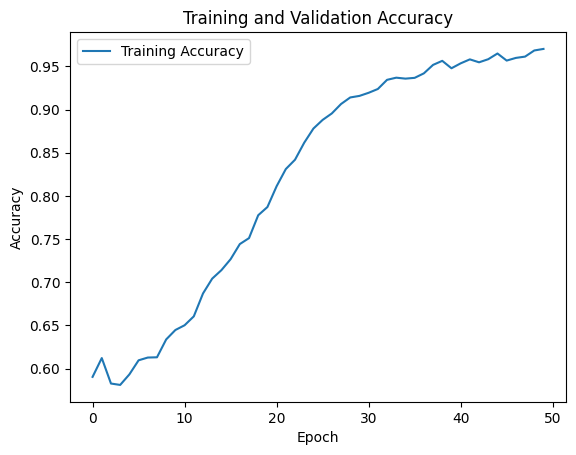

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Creating a Random Classifier for Presentation Purpose

In [ ]:
class RandomClassifier:
    def fit(self, X, y):
        # This is a placeholder method since a random classifier does not require training
        pass

    def predict(self, X):
        # Generate random predictions for the input data
        num_samples = X.shape[0]
        return np.random.randint(2, size=num_samples)  # Assuming binary classification (0 or 1)

# Create an instance of the RandomClassifier
random_model = RandomClassifier()

In [ ]:
# Train the classifier
random_model.fit(x_train_pca, y_train)

# Predict on the test set
y_pred = random_model.predict(x_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.499


Plotting 5 images of each classs

In [ ]:
# Assuming your data is already loaded as test_data and test_labels
test_data = x_test_flat
test_data_pca = ipca.transform(test_data)
predictions = model.predict(x_test_pca)

# The 'predictions' array will contain the predicted probabilities for each sample
test_labels = (predictions > 0.5).astype(int)

# Image shape
image_shape = (240, 240, 3)

# Generate random indices for accidents and non-accidents
accident_indices = np.where(y_test == 1)[0]
non_accident_indices = np.where(y_test == 0)[0]

# Randomly select 5 indices for accidents and non-accidents
random_accident_indices = np.random.choice(accident_indices, size=5, replace=False)
random_non_accident_indices = np.random.choice(non_accident_indices, size=5, replace=False)

# Plot 5 random images of accidents
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_accident_indices, 1):
    plt.subplot(1, 5, i)
    plt.imshow(test_data[idx].reshape(image_shape))
    if test_labels[idx] == y_test[idx]:
        plt.title("Accident", color='green')
    else:
        plt.title("Accident", color='red')
    plt.axis('off')

plt.show()

# Plot 5 random images of non-accidents
plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_non_accident_indices, 1):
    plt.subplot(1, 5, i)
    plt.imshow(test_data[idx].reshape(image_shape))
    if test_labels[idx] == y_test[idx]:
        plt.title("Non-Accident", color='green')
    else:
        plt.title("Non-Accident", color='red')
    plt.axis('off')

plt.show()


NameError: name 'x_test_flat' is not defined

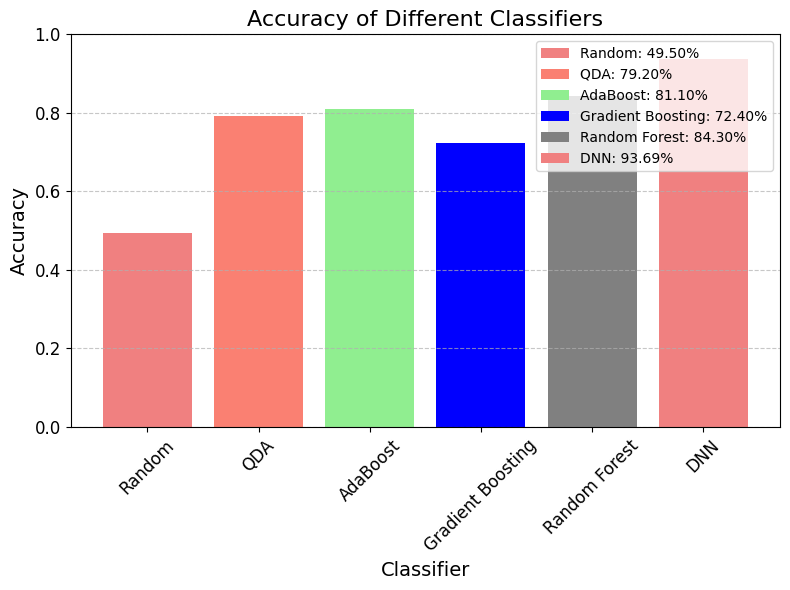

In [ ]:
import matplotlib.pyplot as plt

# Define the accuracies
accuracies = {
    'Random' : 0.495,
    'QDA': 0.792,
    'AdaBoost': 0.811,
    'Gradient Boosting': 0.724,
    'Random Forest': 0.843,
    'DNN': 0.9369
}

# Define colors for each classifier
colors = ['lightcoral', 'salmon', 'lightgreen', 'blue', 'grey']
classifiers = list(accuracies.keys())

# Plot the accuracies
plt.figure(figsize=(8, 6))  # Adjusted figure width
bars = plt.bar(classifiers, accuracies.values(), color=colors)
plt.title('Accuracy of Different Classifiers', fontsize=16)
plt.xlabel('Classifier', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1.0)  # Adjusted y-axis limits to start from 0
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
legend_labels = [f'{classifier}: {accuracy * 100:.2f}%' for classifier, accuracy in accuracies.items()]
plt.legend(bars, legend_labels, loc='upper right', fontsize=10)

plt.tight_layout()  # Adjust layout for better presentation
plt.show()


Upload a random image and test the model on it